## Sensitivity Analysis for Global Seed

This jupyter notebook creates plots to study the impact of varying the global seed for base-case analysis

### 0. Analysis IDs to compare

In [1]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (72, )

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
# Plotly for plotting 
#!pip install plotly

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px

### 2. Environment Variables

In [6]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [8]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [9]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [10]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [11]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(44934,)

In [12]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

count  analysis_id
0    916          410
1    860          412
2    910          409
3    872          413
4    899          411

In [13]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

count  analysis_id
0    907          410
1    858          412
2    906          409
3    865          413
4    896          411

In [14]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

count  analysis_id
0      9          410
1      7          413
2      2          412
3      3          411
4      4          409

In [15]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, ap.param_value as global_seed
from ev_stranded est
         join (
    select param_value, analysis_id
    from analysis_params
    where param_id = 1) as ap
              on est.analysis_id = ap.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY global_seed;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

stranded_lat  stranded_lng  analysis_id global_seed
0     45.699231   -121.412917          411         202
1     45.905055   -121.506886          411         202
2     47.829552   -122.034090          411         202
3     46.956087   -120.297685          412         818
4     47.053961   -124.162857          412         818

In [16]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

sum  analysis_id
0  105225.0          410
1   98698.0          412
2  103911.0          409
3  100583.0          413
4  104921.0          411

In [17]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

count  analysis_id
0    615          410
1    571          412
2    593          409
3    596          413
4    650          411

In [18]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

count  analysis_id
0    113          410
1     91          412
2    102          409
3    110          413
4    145          411

In [19]:
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       ap.param_value               as global_seed
FROM evse_power_draw epd
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on epd.analysis_id = ap.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, ap.param_value
ORDER BY global_seed, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

analysis_id            datetime  total_power global_seed
0             411 2019-07-01 06:00:12            0         202
1             411 2019-07-01 06:01:12            0         202
2             411 2019-07-01 06:02:12            0         202
3             411 2019-07-01 06:03:12            0         202
4             411 2019-07-01 06:04:12            0         202
...           ...                 ...          ...         ...
5954          410 2019-07-02 00:20:45            0         980
5955          410 2019-07-02 00:21:45            0         980
5956          410 2019-07-02 00:22:45            0         980
5957          410 2019-07-02 00:23:45            0         980
5958          410 2019-07-02 00:24:45            0         980

[5959 rows x 4 columns]

In [20]:
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       ap.param_value,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on ets.analysis_id = ap.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
group by ets.analysis_id, ap.param_value, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
count_stats

sim_count  analysis_id param_value  fin_count      evmt  str_count  \
0        910          409         917        906  103911.0          4   
1        916          410         980        907  105225.0          9   
2        899          411         202        896  104921.0          3   
3        860          412         818        858   98698.0          2   
4        872          413         935        865  100583.0          7   

   cs_count  wait_count  
0       593         102  
1       615         113  
2       650         145  
3       571          91  
4       596         110

In [21]:
count_stats.dtypes
count_stats = count_stats.sort_values(by=['param_value'])
count_stats

sim_count  analysis_id param_value  fin_count      evmt  str_count  \
2        899          411         202        896  104921.0          3   
3        860          412         818        858   98698.0          2   
0        910          409         917        906  103911.0          4   
4        872          413         935        865  100583.0          7   
1        916          410         980        907  105225.0          9   

   cs_count  wait_count  
2       650         145  
3       571          91  
0       593         102  
4       596         110  
1       615         113

In [22]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       ap.param_value,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on (lai.row_data -> 'analysis_id')::int = ap.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY ap.param_value
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

start_time  aid                 end_time_tripgen  \
0 2021-02-17 20:34:27.514469+00:00  411 2021-02-17 20:49:58.696261+00:00   
1 2021-02-17 20:34:30.657228+00:00  412 2021-02-17 20:48:49.348017+00:00   
2 2021-02-17 20:34:21.180393+00:00  409 2021-02-17 20:49:40.064208+00:00   
3 2021-02-17 20:34:33.799432+00:00  413 2021-02-17 20:49:23.127088+00:00   
4 2021-02-17 20:34:24.369795+00:00  410 2021-02-17 20:49:31.963089+00:00   

                  action_tstamp_tx   ev_count param_value  time_taken_tripgen  \
0 2021-02-18 00:21:54.944043+00:00  # EV: 899         202                15.0   
1 2021-02-17 23:54:25.030451+00:00  # EV: 860         818                14.0   
2 2021-02-18 00:32:17.898018+00:00  # EV: 910         917                15.0   
3 2021-02-18 00:10:52.279226+00:00  # EV: 872         935                14.0   
4 2021-02-18 00:23:23.732084+00:00  # EV: 916         980                15.0   

   time_taken_eviabm  
0              211.0  
1              185.0  
2              222.0  
3              201.0  
4              213.0

### 5. Plotting

#### 5.1 Vehicle Counts

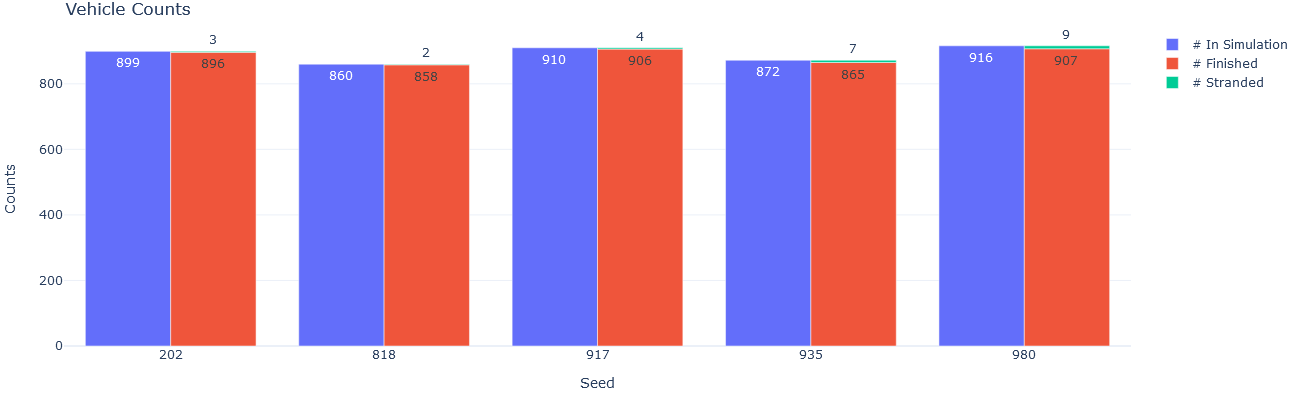

In [23]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['param_value'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['param_value'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['param_value'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.2 eVMT

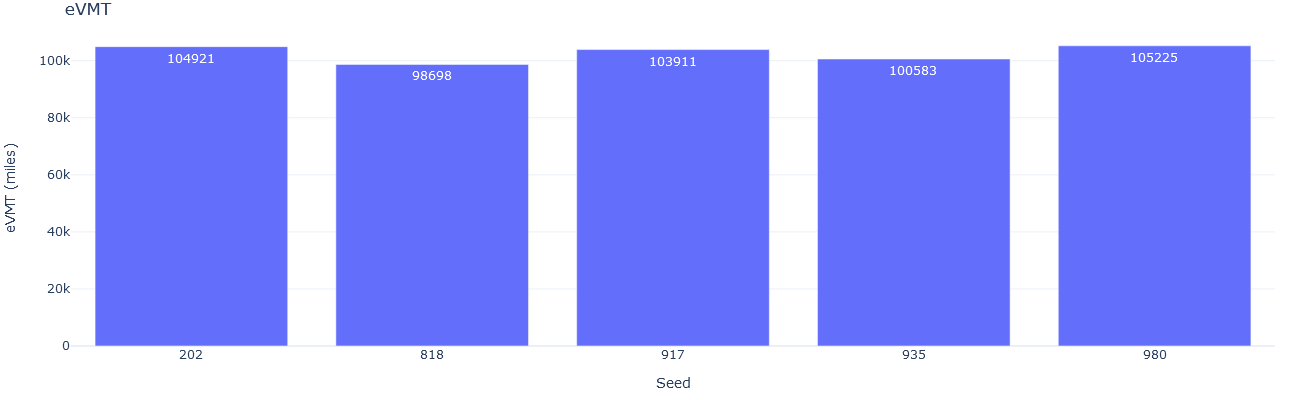

In [24]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['param_value'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="Seed", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category')

fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

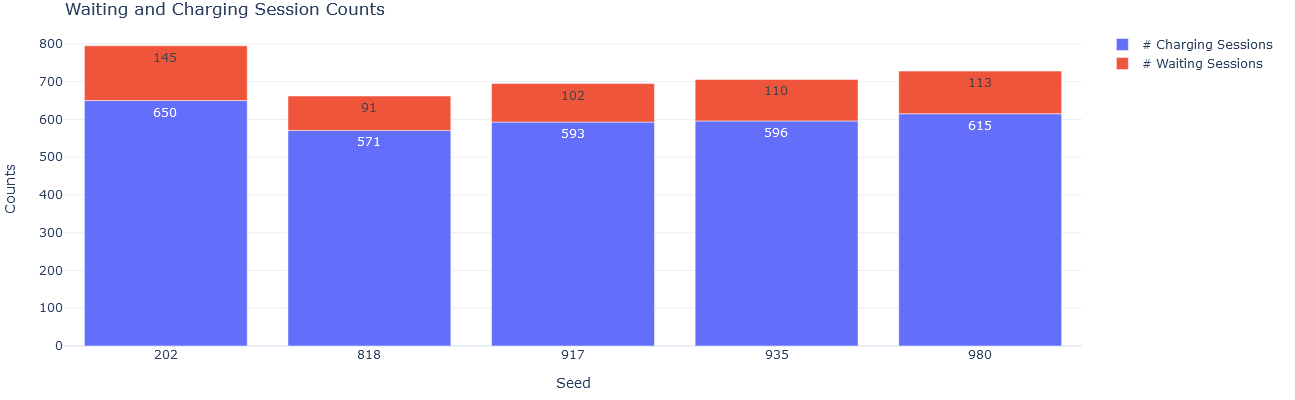

In [25]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['param_value'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['param_value'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

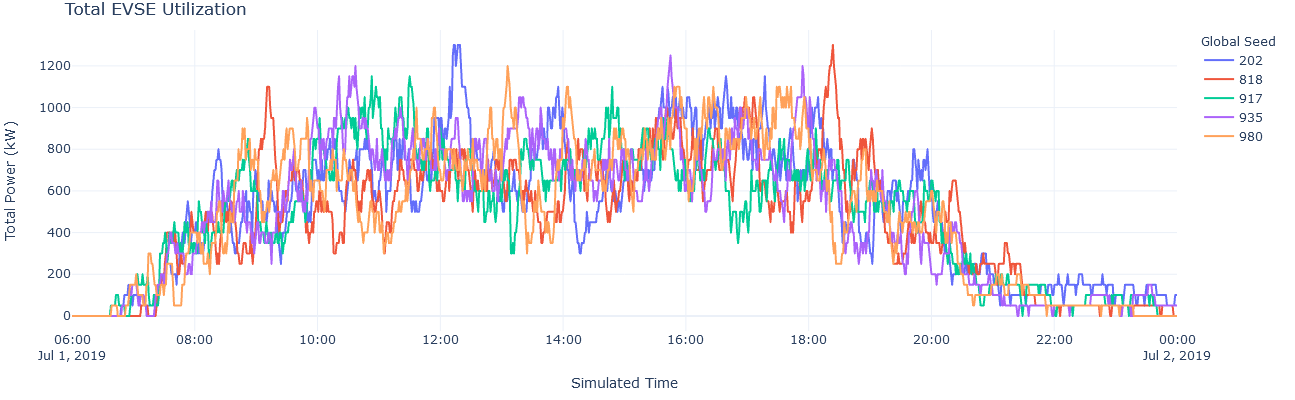

In [26]:
fig = px.line(evse_util, x="datetime", y="total_power", color='global_seed', labels={"global_seed": 'Global Seed'}, range_x=['2019-07-01 06:00','2019-07-02'])
fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white')
fig.show()

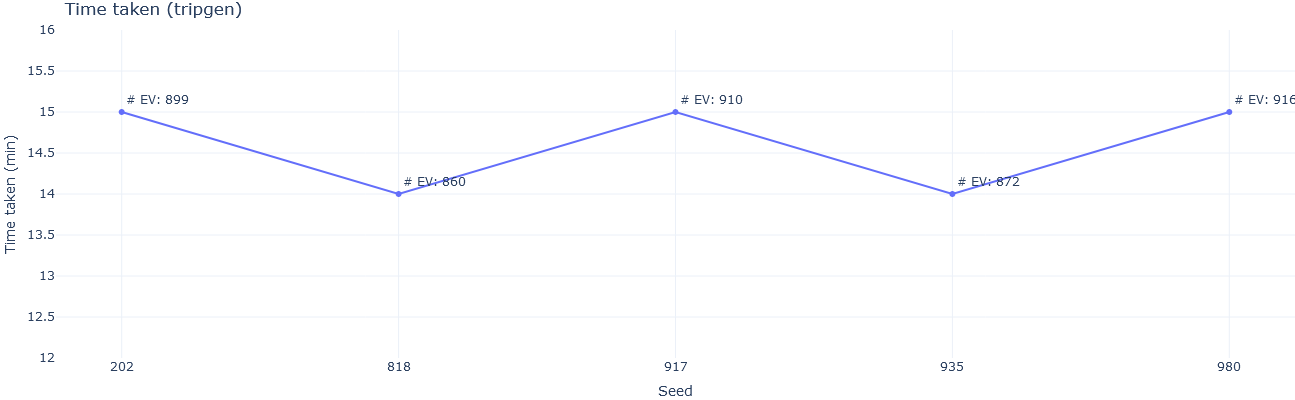

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='lines+markers', 
                         text=comp_stats['ev_count'],
                         textposition="top right"))
fig.update_xaxes(type='category', automargin=True)
fig.update_yaxes(range=(12, 16))
fig.update_layout(title="Time taken (tripgen)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=0, t=30, b=20),
                 template='plotly_white')
fig.show()

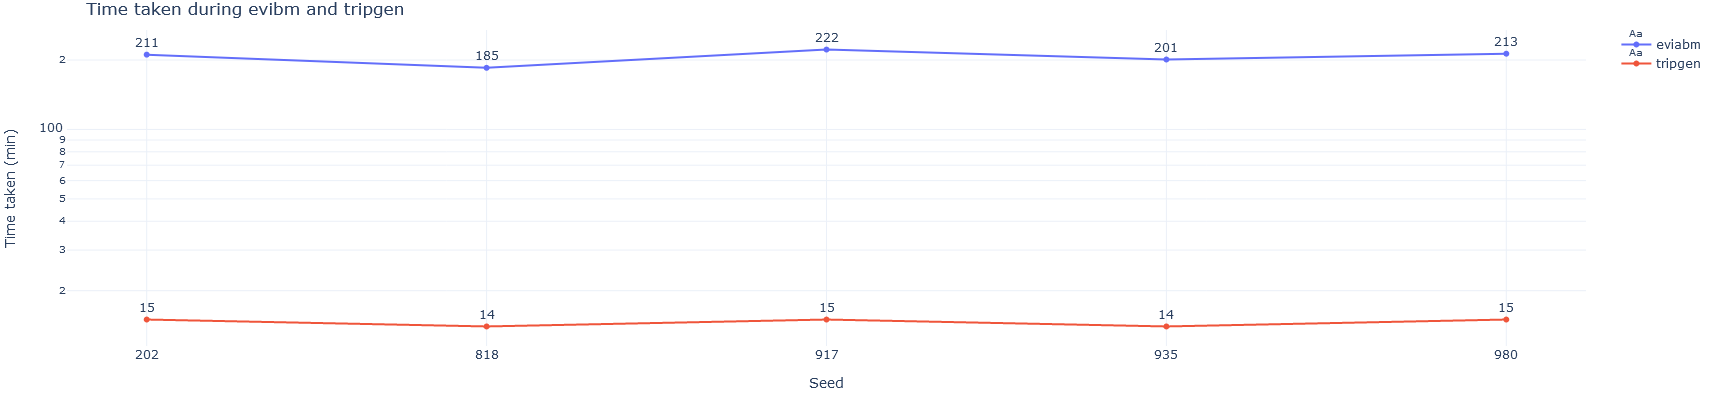

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_eviabm'],
                    mode='lines+markers+text',
                    name='eviabm', text=comp_stats['time_taken_eviabm'],
                    textposition="top center"))
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='tripgen', text=comp_stats['time_taken_tripgen'],
                         textposition="top center"))
fig.update_xaxes(type='category')
fig.update_yaxes( type="log")
fig.update_layout(title="Time taken during evibm and tripgen",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=600, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20),
                  template='plotly_white')
fig.show()

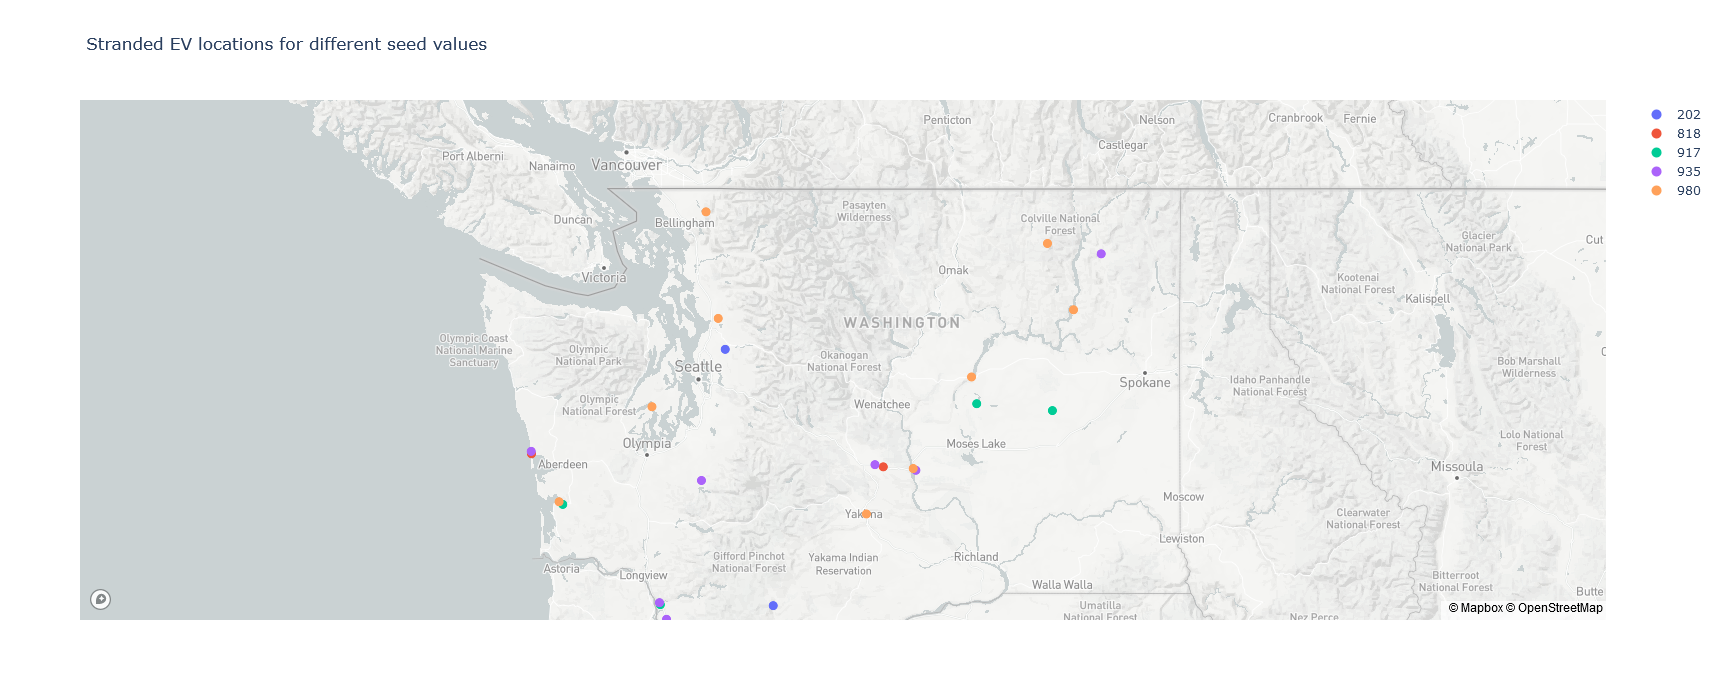

In [30]:
fig = go.Figure()
token = os.getenv("MAPBOX_ACCESS_TOKEN")
for seed in evs_str_loc['global_seed'].unique():
    fig.add_trace(go.Scattermapbox(
            lat=evs_str_loc[evs_str_loc['global_seed'] == seed]['stranded_lat'],
            lon=evs_str_loc[evs_str_loc['global_seed'] == seed]['stranded_lng'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=10
            ), 
            name = seed
        ))

fig.update_layout(
        title_text = 'Stranded EV locations for different seed values',
        showlegend = True,
        mapbox_style="light", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700
    )

fig.show()

In [34]:
from datetime import datetime, timedelta

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))


In [35]:
sql_ev_ts = """select ets.analysis_id, trip_start_time, ap.param_value from evtrip_scenarios ets join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on ets.analysis_id = ap.analysis_id where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s) order by ap.param_value"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
ev_ts = pd.read_sql_query(sql=sql_ev_ts, con=conn, params=(set_id,))
ev_ts

analysis_id      trip_start_time param_value
0             411  2019-07-01 18:28:30         202
1             411  2019-07-01 14:22:45         202
2             411  2019-07-01 11:42:10         202
3             411  2019-07-01 07:40:48         202
4             411  2019-07-01 10:50:54         202
...           ...                  ...         ...
4452          410  2019-07-01 08:51:07         980
4453          410  2019-07-01 06:30:48         980
4454          410  2019-07-01 15:27:03         980
4455          410  2019-07-01 06:08:55         980
4456          410  2019-07-01 07:40:38         980

[4457 rows x 3 columns]

In [36]:
ev_ts.dtypes

analysis_id         int64
trip_start_time    object
param_value        object
dtype: object

In [37]:
ev_ts['rouded_time'] = pd.to_datetime(ev_ts['trip_start_time']).apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))

In [38]:
fig = px.histogram(ev_ts[ev_ts['analysis_id']==29], x="rouded_time")

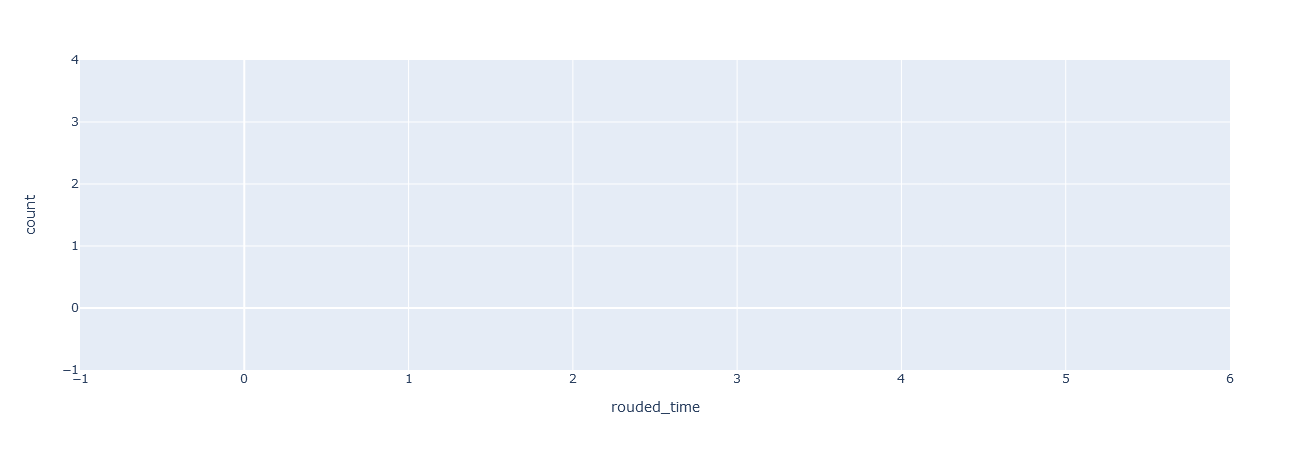

In [39]:
fig.show()

In [40]:
analysis_ids = ev_ts['analysis_id'].unique()

411
412
409
413
410


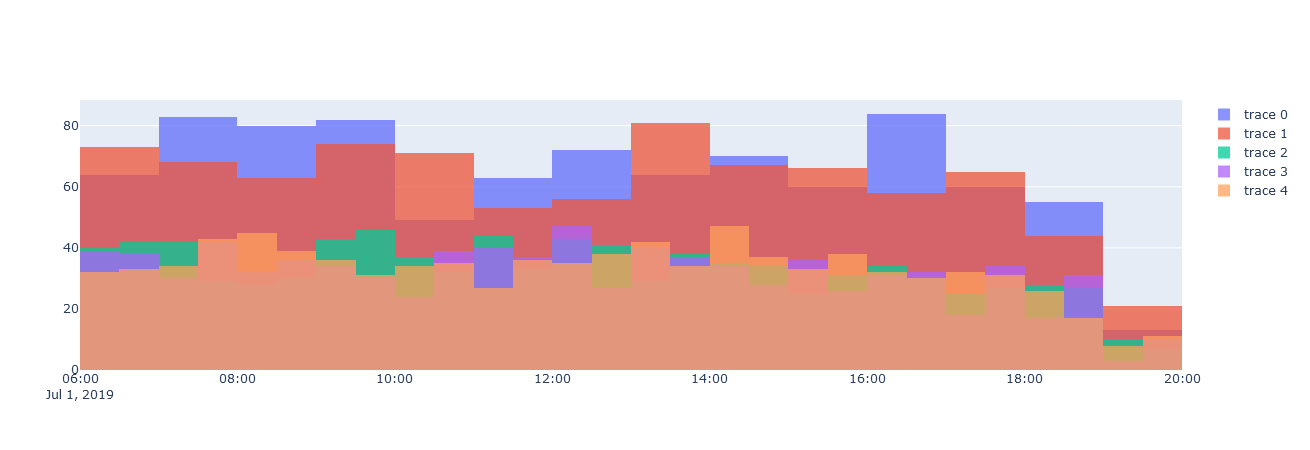

In [41]:
fig = go.Figure()
for i in analysis_ids:
    print(i)
    fig.add_trace(go.Histogram(x=ev_ts['rouded_time'][ev_ts['analysis_id']==i]))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [ ]:
#!jupyter labextension list

In [ ]:
#!jupyter labextension uninstall jupyterlab-plotly

In [ ]:
#!jupyter labextension uninstall plotlywidget

In [ ]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [ ]:
#!pip show plotly

In [ ]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [ ]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [ ]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [ ]:
#!pip install "nbconvert<6"